In [2]:
import eDiskplot as eplot
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import AsinhStretch, ImageNormalize
from eDisk_source_dict import source_dict
import analysis_utils as au
from qdisk.product import calculate_averaged_spectra, calculate_pvdiagram, calculate_moment, calculate_radial_profile
from qdisk.model import Keplerian_velocity
import qdisk.utils as utils
from qdisk.plot import plot_2D_map
from qdisk.classes import FitsImage
from qdisk.utils import is_within
from matplotlib import ticker
%matplotlib widget
%load_ext autoreload
%autoreload 2



source = "L1489IRS"
baseline = "SBLB"
line = "C18O"
robust=1.0
vsys = source_dict[source]["v_sys"]
center_coord = source_dict[source]["radec"]
RAlabel = "$\Delta$R.A. [arcsec]"
Declabel = "$\Delta$Dec. [arcsec]"
vrange = 5
rmax = 8
norm_kwargs = {"M0": dict(stretch=AsinhStretch(a=0.1), vmin=0.0),
               "M1": dict(vmin=vsys-vrange, vmax=vsys+vrange),
               "M8": dict()}
moment_chunks = 4
imagename = au.customimagepath + au.get_image_basename(source, baseline, line, robust=robust)

In [3]:
from eDiskplot import plot_rotation_map

In [4]:
rotmapname = au.VADPpath + au.get_image_basename(
    source, baseline, line, robust=robust
).replace(".fits", "_v0.fits")


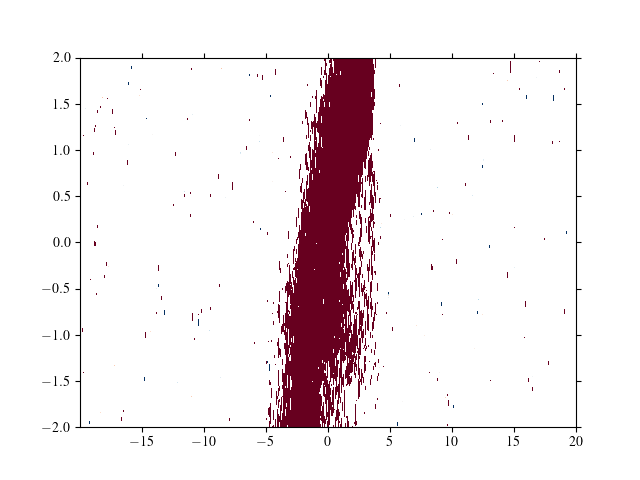

In [13]:
rotmap = FitsImage(rotmapname)

cube = FitsImage(imagename)
cube.shift_phasecenter_toward(center_coord)
cube.estimate_rms(edgenchan=3)

assert rotmap.data.shape == cube.data.shape[1:]

# generate threshold mask
cube.get_threshold_mask(threshold=4)
cube.shift_phasecenter_toward(center_coord)

threshold_mask = np.sum(cube.threshold_mask, axis=0) >= 1.0

# velocity range mask
vrange_mask = (rotmap.data <= vsys + 1.5) & (rotmap.data >= vsys - 1.5)

rotmap.data[~vrange_mask & ~threshold_mask] = np.nan

fig, ax = plt.subplots()

rotmap.data = rotmap.data[is_within(rotmap.y, (-2, 2)), :]
rotmap.y = rotmap.y[is_within(rotmap.y, (-2, 2))]

ax.pcolorfast(rotmap.x, rotmap.y, rotmap.data, rasterized=True, cmap=au.cmap["M1"], vmin=vsys-vrange, vmax=vsys+vrange)

In [ ]:

fig, ax = plot_rotation_map(
    rotmapname,
    imagename,
    center_coord=center_coord,
    xlim=(-rmax, rmax),
    ylim=(-rmax, rmax),
    vrange=vrange,
    vsys=vsys,
    figsize=(3.6,3)
)

ax.xaxis.set_major_locator(ticker.MaxNLocator(7))
ax.yaxis.set_major_locator(ticker.MaxNLocator(7))


In [32]:
fig.savefig("./figure/L1489IRS_SBLB_C18O_robust_1.0.image_rotationmap.png", bbox_inches="tight", pad_inches=0.01, dpi=500)

In [109]:
image = FitsImage(imagename)
image.get_directional_coord(center_coord=center_coord)


In [43]:
# make more sophisticated mask
# channel binning to enhance S/N

def channel_rebin(data, factor=1):
    end = factor * int(data.shape[0] / factor)
    shape = (-1, factor, data.shape[1], data.shape[2])
    resampled = np.nanmean(data[:end].reshape(shape), axis=1)
    return resampled

resampled = channel_rebin(image.data, factor=4)

/tmp/ipykernel_1262909/2803914551.py:7: RuntimeWarning: Mean of empty slice
  resampled = np.nanmean(data[:end].reshape(shape), axis=1)


In [42]:
def image_rebin(data, factor=1):
    assert data.shape[1] == data.shape[2]
    end = factor * int(data.shape[1] / factor)
    shape1 = (data.shape[0], -1, factor, data.shape[2])
    data = np.nanmean(data[:, :end, :].reshape(shape1), axis=2)
    shape2 = (data.shape[0], data.shape[1], -1, factor)
    resampled = np.nanmean(data[:,:,:end].reshape(shape2), axis=3)
    return resampled

resampled = image_rebin(image.data, factor=1)

/tmp/ipykernel_1269705/481565809.py:5: RuntimeWarning: Mean of empty slice
  data = np.nanmean(data[:, :end, :].reshape(shape1), axis=2)


KeyboardInterrupt: 

In [25]:
# measure rms
rms = np.nanstd([resampled[:3], resampled[-3:]])
rms

0.0014196665

[None]

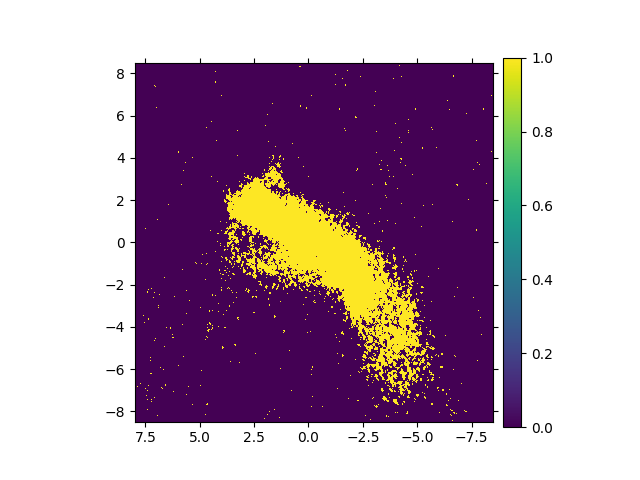

In [286]:
# from scipy.signal import resample
# # resampled[resampled < 2*rms] = False
# # resampled[resampled >= 2*rms] = True
# image.estimate_rms(edgenchan=3)
# mask = image.data.copy()
# mask[mask < 4*rms] = False
# mask[mask >= 4*rms] = True
# mask = np.nansum(mask, axis=0)>=1.0

# print(mask.max())

image.get_threshold_mask(threshold=4)

mask = np.sum(image.threshold_mask, axis=0) >= 1.0



# mask = resample(mask, 4000, axis=0)
# mask = resample(mask, 4000, axis=1)

fig = plot_2D_map(
    mask,
    X=image.x,
    Y=image.y,
    # ax=ax,
    cmap_method="pcolorfast",
    contour=False,
    # cmap_kw=dict(cmap=au.cmap["M1"], vmin=vsys - vrange, vmax=vsys + vrange),
    xlim=(-8.5, 8,5),
    ylim=(-8.5, 8.5),
)

fig.axes.set(aspect=1./fig.axes.get_data_ratio())

In [257]:
import cv2 

# kernel = np.ones((10,10),np.uint8)
# masked = cv2.medianBlur(mask.astype(np.float32), ksize=5)

masked = mask.astype(float).copy()

# kernel = np.ones((8, 8), np.uint8)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11))

masked = cv2.erode(masked, kernel, iterations = 1)
masked = cv2.dilate(masked, kernel, iterations=1)


# from astropy.convolution import convolve, Gaussian2DKernel

# conv_kernel = Gaussian2DKernel(x_stddev=1000, y_stddev=1000)
# masked = convolve(masked, kernel)
# masked = cv2.morphologyEx(mask.astype(float), cv2.MORPH_OPEN, kernel)
# closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)

[None]

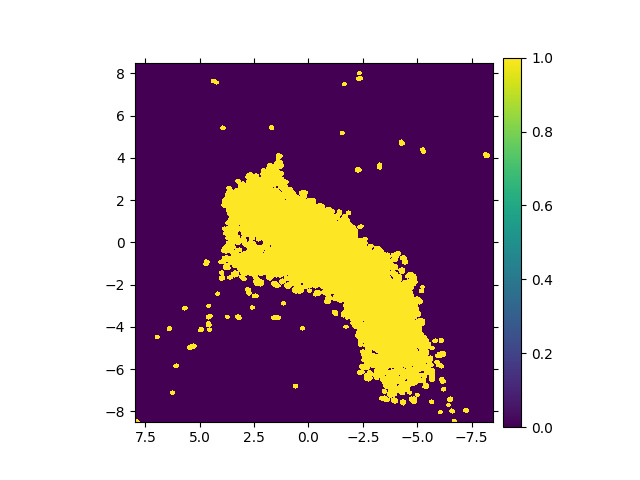

In [252]:
fig = plot_2D_map(
    masked,
    X=image.x,
    Y=image.y,
    # ax=ax,
    cmap_method="pcolorfast",
    contour=False,
    # cmap_kw=dict(cmap=au.cmap["M1"], vmin=vsys - vrange, vmax=vsys + vrange),
    xlim=(-8.5, 8,5),
    ylim=(-8.5, 8.5),
)

fig.axes.set(aspect=1./fig.axes.get_data_ratio())

In [106]:
calculate_moment(
    imagename,
    moments=["q"],
    threshold=None,
    save=True,
    savefilename=au.VADPpath
    + au.get_image_basename(source, baseline, line, robust=robust),
)


Loading data...
Estimating rms...
Generating threshold mask...
Generating channel mask...
Combining the masks...
Calculating moment q...


/home/yamato/Project/eDisk/firstlook_L1489IRS/.venv/lib/python3.8/site-packages/bettermoments/quadratic.py:68: RuntimeWarning: invalid value encountered in true_divide
  x_max = idx - 0.5 * a1 / a2
/home/yamato/Project/eDisk/firstlook_L1489IRS/.venv/lib/python3.8/site-packages/bettermoments/quadratic.py:69: RuntimeWarning: invalid value encountered in true_divide
  y_max = a0 - 0.25 * a1**2 / a2
/home/yamato/Project/eDisk/firstlook_L1489IRS/.venv/lib/python3.8/site-packages/bettermoments/quadratic.py:109: RuntimeWarning: invalid value encountered in true_divide
  x_max_var = 0.0625*(a1**2*(df_minus + df_plus) +
/home/yamato/Project/eDisk/firstlook_L1489IRS/.venv/lib/python3.8/site-packages/bettermoments/quadratic.py:113: RuntimeWarning: invalid value encountered in true_divide
  y_max_var = 0.015625*(a1**4*(df_minus + df_plus) +


{'q': array([[[-2999.99996491, -2999.99996491, -2999.99996491, ...,
          -2999.99996491, -2999.99996491, -2999.99996491],
         [-2999.99996491, -2999.99996491, -2999.99996491, ...,
          -2999.99996491, -2999.99996491, -2999.99996491],
         [-2999.99996491, -2999.99996491, -2999.99996491, ...,
          -2999.99996491, -2999.99996491, -2999.99996491],
         ...,
         [-2999.99996491, -2999.99996491, -2999.99996491, ...,
          -2999.99996491, -2999.99996491, -2999.99996491],
         [-2999.99996491, -2999.99996491, -2999.99996491, ...,
          -2999.99996491, -2999.99996491, -2999.99996491],
         [-2999.99996491, -2999.99996491, -2999.99996491, ...,
          -2999.99996491, -2999.99996491, -2999.99996491]],
 
        [[           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
  

In [93]:
rotmapname = au.VADPpath + au.get_image_basename(
    source, baseline, line, robust=robust
).replace(".fits", "_v0.fits")

rotmap = FitsImage(rotmapname)
rotmap.get_directional_coord(center_coord=center_coord)

[None,
 Text(0.5, 0, '$\\Delta$R.A. [arcsec]'),
 Text(0, 0.5, '$\\Delta$Dec. [arcsec]')]

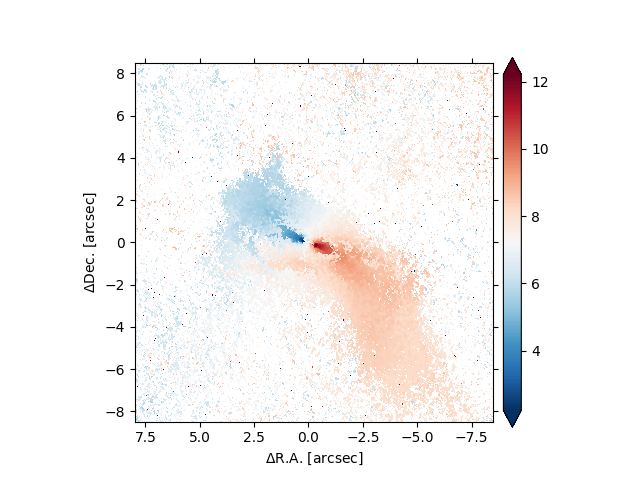

In [283]:
fig, ax = plt.subplots()
finalmap = rotmap.data*1e-3
# finalmap[finalmap == 0.0] = np.nan
# mask = rotmap.data*1e-3
# mask[(rotmap.data*1e-3 < 13) & (rotmap.data*1e-3 > 2)] = 1.0
# mask[(rotmap.data*1e-3 >= 13) | (rotmap.data*1e-3 <= 2)] = 0.0

# kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))

# mask = cv2.erode(mask, kernel, iterations = 5)
# mask = cv2.dilate(mask, kernel, iterations=3)

# plot = finalmap * masked
deltav = 1.5

finalmap[((finalmap > vsys+deltav) | (finalmap < vsys-deltav)) & (mask != 1.0)] = np.nan

plot_2D_map(
    finalmap,
    X=rotmap.x,
    Y=rotmap.y,
    ax=ax,
    cmap_method="pcolorfast",
    contour=False,
    cmap_kw=dict(cmap=au.cmap["M1"], vmin=vsys - vrange, vmax=vsys + vrange),
    xlim=(-8.5, 8,5),
    ylim=(-8.5, 8.5),
)

ax.set(aspect=1.0 / ax.get_data_ratio(), xlabel=RAlabel, ylabel=Declabel)

In [265]:
vsys

7.22

In [4]:
import cv2

image = rotmap.data.copy() * 1e-3

thresh = cv2.threshold(image, 2, 13, cv2.THRESH_BINARY_INV)[1]

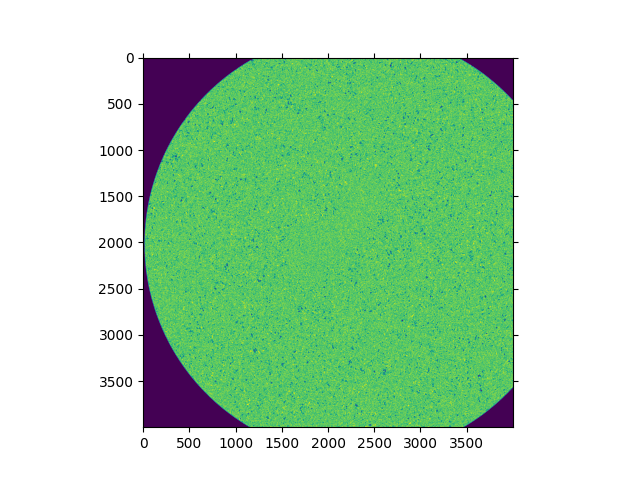

In [6]:
plt.figure()
plt.imshow(thresh)

In [ ]:

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)

/home/yamato/Project/eDisk/firstlook_L1489IRS/.venv/lib/python3.8/site-packages/matplotlib/image.py:443: RuntimeWarning: overflow encountered in double_scalars
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/yamato/Project/eDisk/firstlook_L1489IRS/.venv/lib/python3.8/site-packages/matplotlib/image.py:446: RuntimeWarning: invalid value encountered in double_scalars
  newmin = vmid - dv * fact


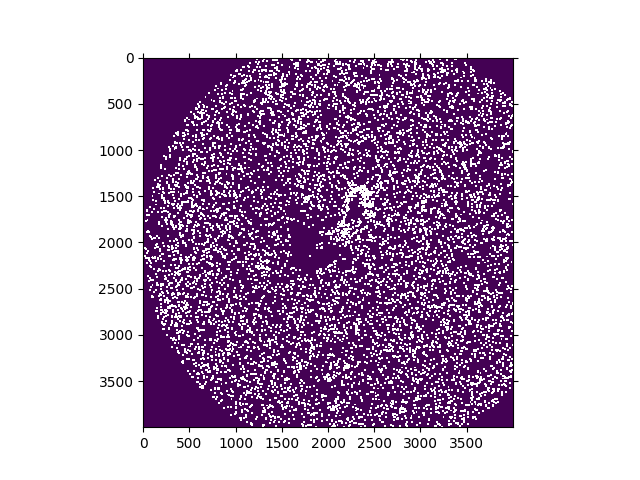

In [158]:
plt.figure()
plt.imshow(result)

In [131]:
factor = 10

data = rotmap.data.copy() * 1e-3

assert data.shape[0] == data.shape[1]
end = factor * int(data.shape[0] / factor)
shape1 = (-1, factor, data.shape[1])
data = np.nanstd(data[:end, :].reshape(shape1), axis=1)
shape2 = (data.shape[0], -1, factor)
resampled = np.nanstd(data[:,:end].reshape(shape2), axis=2)

[None,
 Text(0.5, 0, '$\\Delta$R.A. [arcsec]'),
 Text(0, 0.5, '$\\Delta$Dec. [arcsec]')]

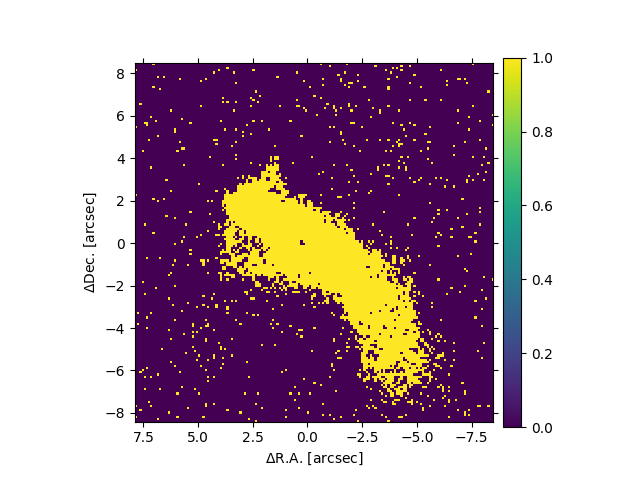

In [137]:
fig = plot_2D_map(
    resampled<=0.5,
    X=rotmap.x[::factor],
    Y=rotmap.y[::factor],
    cmap_method="pcolorfast",
    contour=False,
    # cmap_kw=dict(cmap=au.cmap["M1"], vmin=vsys - vrange, vmax=vsys + vrange),
    xlim=(-8.5, 8,5),
    ylim=(-8.5, 8.5),
)

fig.axes.set(aspect=1.0 / fig.axes.get_data_ratio(), xlabel=RAlabel, ylabel=Declabel)

In [143]:
mask = resampled<=0.5

mask = resample(mask, 4000, axis=0)
mask = resample(mask, 4000, axis=1)

mask = mask>=0.5


[None,
 Text(0.5, 0, '$\\Delta$R.A. [arcsec]'),
 Text(0, 0.5, '$\\Delta$Dec. [arcsec]')]

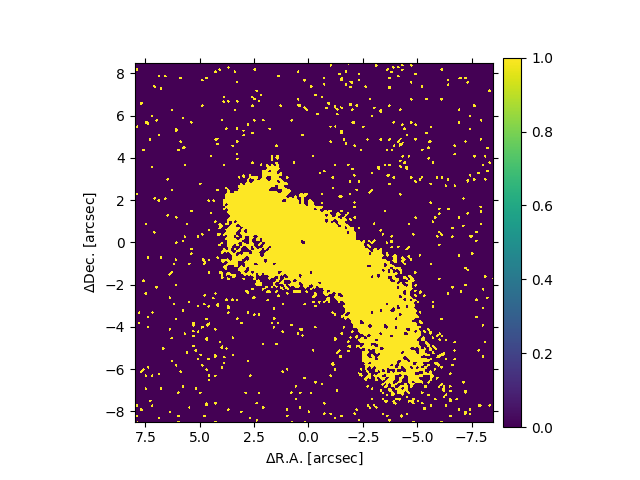

In [144]:
fig = plot_2D_map(
    mask,
    X=rotmap.x,
    Y=rotmap.y,
    cmap_method="pcolorfast",
    contour=False,
    # cmap_kw=dict(cmap=au.cmap["M1"], vmin=vsys - vrange, vmax=vsys + vrange),
    xlim=(-8.5, 8,5),
    ylim=(-8.5, 8.5),
)

fig.axes.set(aspect=1.0 / fig.axes.get_data_ratio(), xlabel=RAlabel, ylabel=Declabel)

[None,
 Text(0.5, 0, '$\\Delta$R.A. [arcsec]'),
 Text(0, 0.5, '$\\Delta$Dec. [arcsec]')]

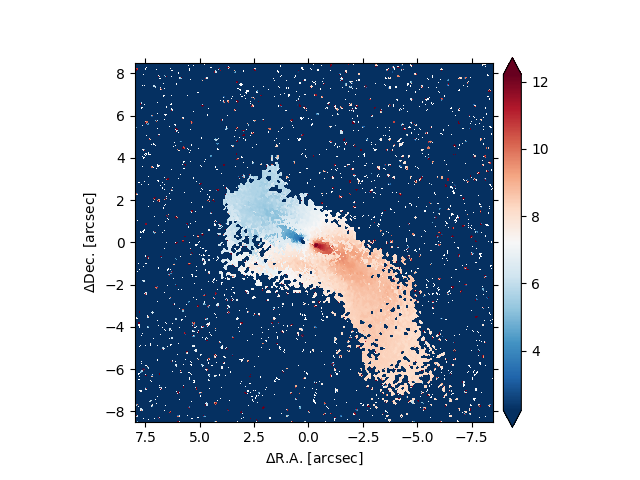

In [145]:
# plot rotation map
rotmapname = au.VADPpath + au.get_image_basename(
    source, baseline, line, robust=robust
).replace(".fits", "_v0.fits")

fig, ax = plt.subplots()

rotmap = FitsImage(rotmapname)
rotmap.get_directional_coord(center_coord=center_coord)

# print(rotmap.data)
data = rotmap.data * 1e-3

### some workaround for bettermoments
data[data == np.min(data)] = np.nan
# data[~is_within(data, (vsys - vrange, vsys + vrange))] = np.nan

plot_2D_map(
    data*mask,
    X=rotmap.x,
    Y=rotmap.y,
    ax=ax,
    cmap_method="pcolorfast",
    contour=False,
    cmap_kw=dict(cmap=au.cmap["M1"], vmin=vsys - vrange, vmax=vsys + vrange),
    xlim=(-8.5, 8,5),
    ylim=(-8.5, 8.5),
)

ax.set(aspect=1.0 / ax.get_data_ratio(), xlabel=RAlabel, ylabel=Declabel)
# ax.xaxis.


In [6]:
np.nanmin(data)

-2.84997775623581

In [27]:
fig.savefig(
    au.figurepath
    + au.get_image_basename(source, baseline, line, robust=robust).replace(
        ".fits", "_v0.png"
    ),
    dpi=500,
    bbox_inches="tight",
    pad_inches=0.01,
)


[None, (5.0, -5.0), (-5.0, 5.0)]

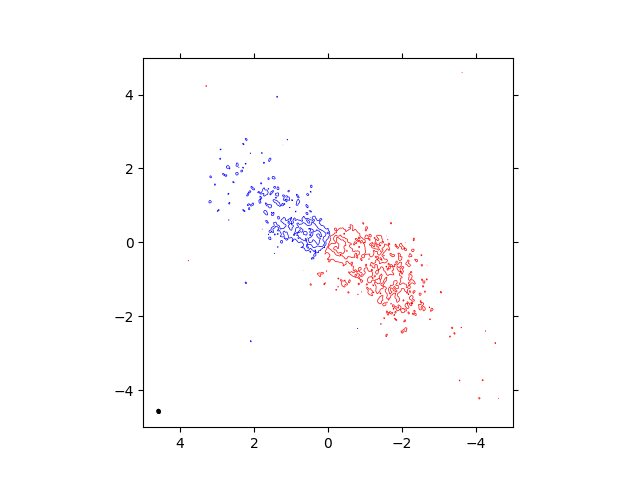

In [5]:
fig, ax = plt.subplots()

# blue
image.spectrally_collapse(vrange=(0.3, vsys), sigma_clip=None, mode="integ")

# # measure the noise levels of collapsed
# image.get_mask(rmin=12, rmax=14)

noise = np.nanstd(image.collapsed)

utils.plot_2D_map(
    image.collapsed,
    X=image.x,
    Y=image.y,
    ax=ax,
    # cmap=True,
    # cmap_method="pcolorfast",
    # contour=False,
    cmap=False,
    contour=True,
    colorbar=False,
    beam=image.beam,
    beam_kw=dict(color="black"),
    contour_kw=dict(
        levels=np.linspace(4 * noise, image.collapsed.max(), 4),
        colors="blue",
        linewidths=0.5,
    ),
)

# red
image.spectrally_collapse(vrange=(vsys, 13), sigma_clip=None, mode="integ")

# # measure the noise levels of collapsed
# image.get_mask(rmin=12, rmax=14)

noise = np.nanstd(image.collapsed)

utils.plot_2D_map(
    image.collapsed,
    X=image.x,
    Y=image.y,
    ax=ax,
    # cmap=True,
    # cmap_method="pcolorfast",
    # contour=False,
    cmap=False,
    contour=True,
    colorbar=False,
    beam=image.beam,
    beam_kw=dict(color="black", fill=True, linewidths=0.5),
    contour_kw=dict(
        levels=np.linspace(4 * noise, image.collapsed.max(), 4),
        colors="red",
        linewidths=0.5,
    ),
)

ax.set(aspect=1.0 / ax.get_data_ratio(), xlim=(5, -5), ylim=(-5, 5))


In [3]:
# check channel maps to determine the emission extent
eplot.plot_channel_map(
    imagename,
    center_coord=center_coord,
    rmax=5,
    vrange=None,
    thin=5,
    sigma_clip=None,
    pad=0.2,
)


Loading data...


FileNotFoundError: [Errno 2] No such file or directory: '/raid/work/yamato/edisk_data/L1489IRS/custom_images/L1489IRS_SBLB_C18O_robust_0.5.image.fits'

In [3]:
# moment 0
moment = 0
mom0name = au.VADPpath + au.get_image_basename(source, baseline, line)
# calculate_moment(imagename, moments=[moment], vel_extent=source_dict[source]["emission_extent"][line], save=True, savefilename=mom0name, nchunks=moment_chunks)


[(5.0, -5.0), (-5.0, 5.0), None]

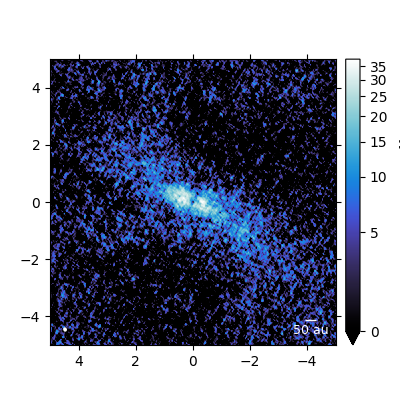

In [14]:
# plot mooment 0
fig, ax = plt.subplots(figsize=(4, 4))

eplot.plot_map(
    mom0name.replace(".fits", "_M0.fits"),
    ax=ax,
    center_coord=center_coord,
    data_scaling_factor=au.data_scaling_factor["M0"],
    cmap=eplot.cmap["M0"],
    norm_kwargs=norm_kwargs["M0"],
    cbar_kw=au.cbar_kw["M0"],
    beam_kw=au.beam_kw["M0"],
    sbar_kw=au.sbar_kw["M0"],
)
ax.set(xlim=(5, -5), ylim=(-5, 5), aspect=1.0 / ax.get_data_ratio())


In [4]:
# radial profile
rmax = 2
wedge_angle = 90
calculate_radial_profile(
    imagename=mom0name.replace(".fits", "_M0.fits"),
    PA=source_dict[source]["PA"],
    incl=source_dict[source]["incl"],
    center_coord=center_coord,
    rmax=rmax,
    wedge_angle=wedge_angle,
    save=True,
    savefileheader="r [arcsec] \t I [mJy/beam km/s] \t dI [mJy/beam km/s]",
)


Loading data...
Calculating radial profile...


(array([0.01296218, 0.03888653, 0.06481088, 0.09073523, 0.11665958,
        0.14258393, 0.16850828, 0.19443264, 0.22035699, 0.24628134,
        0.27220569, 0.29813004, 0.32405439, 0.34997874, 0.3759031 ,
        0.40182745, 0.4277518 , 0.45367615, 0.4796005 , 0.50552485,
        0.5314492 , 0.55737356, 0.58329791, 0.60922226, 0.63514661,
        0.66107096, 0.68699531, 0.71291967, 0.73884402, 0.76476837,
        0.79069272, 0.81661707, 0.84254142, 0.86846577, 0.89439013,
        0.92031448, 0.94623883, 0.97216318, 0.99808753, 1.02401188,
        1.04993623, 1.07586059, 1.10178494, 1.12770929, 1.15363364,
        1.17955799, 1.20548234, 1.23140669, 1.25733105, 1.2832554 ,
        1.30917975, 1.3351041 , 1.36102845, 1.3869528 , 1.41287715,
        1.43880151, 1.46472586, 1.49065021, 1.51657456, 1.54249891,
        1.56842326, 1.59434761, 1.62027197, 1.64619632, 1.67212067,
        1.69804502, 1.72396937, 1.74989372, 1.77581807, 1.80174243,
        1.82766678, 1.85359113, 1.87951548, 1.90

[(0.0, 1.9),
 (0.0, 34.0),
 Text(0.5, 0, 'Radius [arcsec]'),
 Text(0, 0.5, 'I [mJy beam$^{-1}$ km s$^{-1}$]')]

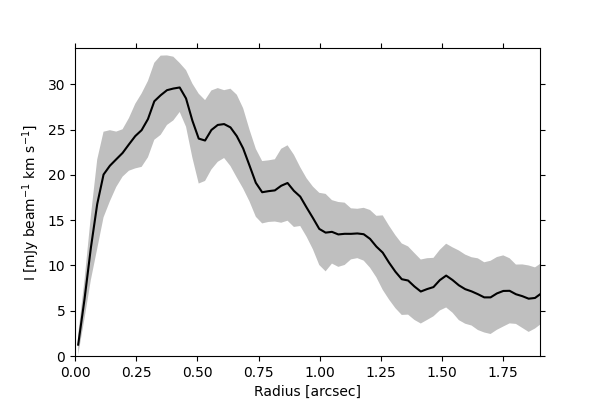

In [5]:
# plot radial profile
fig, ax = plt.subplots(figsize=(6, 4))

eplot.plot_radial_profile(
    mom0name.replace(".fits", "_M0_radialProfileWedge90deg.txt"), ax=ax, color="black"
)
ax.set(
    xlim=(0, 1.9),
    ylim=(0, 34),
    xlabel="Radius [arcsec]",
    ylabel="I [mJy beam$^{-1}$ km s$^{-1}$]",
)


[(0.0, 1.9),
 (0.0, 1.3),
 Text(0.5, 0, 'Radius [arcsec]'),
 Text(0, 0.5, 'I [mJy beam$^{-1}$ km s$^{-1}$]')]

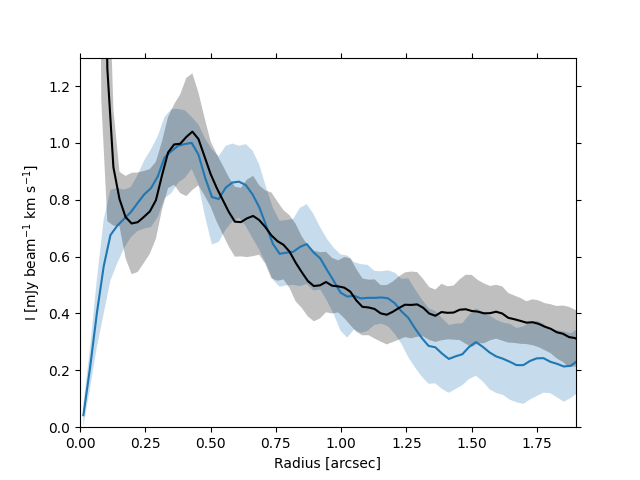

In [15]:
# comparison with continuum
contprofile = (
    "./VADP/L1489IRS_SBLB_continuum_robust_1.0.image.tt0_radialProfileWedge90deg.txt"
)
fig, ax = plt.subplots()

eplot.plot_radial_profile(
    mom0name.replace(".fits", "_M0_radialProfileWedge90deg.txt"),
    ax=ax,
    color="tab:blue",
    normalize=True,
)
eplot.plot_radial_profile(contprofile, ax=ax, color="black", normalize=True, scale=25)
ax.set(
    xlim=(0, 1.9),
    ylim=(0, 1.3),
    xlabel="Radius [arcsec]",
    ylabel="I [mJy beam$^{-1}$ km s$^{-1}$]",
)


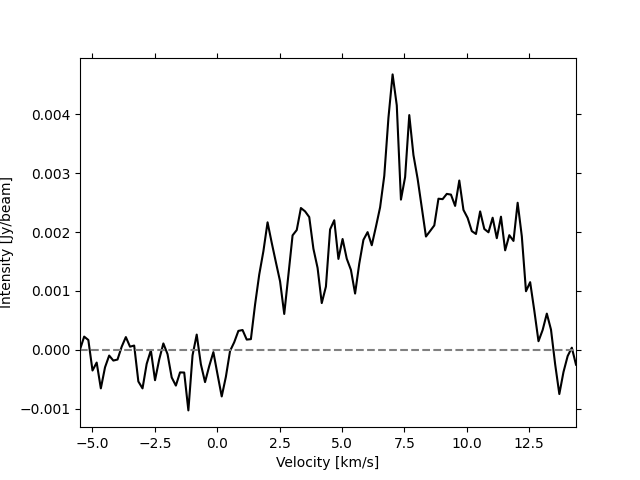

In [4]:
# check spectrum
line = "C18O"
imagename = au.imageproductpath + au.get_image_basename(
    source, baseline, line, robust=0.5
)

v, spec = calculate_averaged_spectra(imagename, rmin=0.1, rmax=0.5, PA=80, incl=73)

fig, ax = utils.plot_1D_profile(x=v, y=spec)
ax.set(xlabel="Velocity [km/s]", ylabel="Intensity [Jy/beam]")
ax.axhline(y=0.0, color="grey", ls="dashed")


Loading data...
Plotting v = 0.01 km/s...
Plotting v = 0.68 km/s...
Plotting v = 1.35 km/s...
Plotting v = 2.01 km/s...
Plotting v = 2.68 km/s...
Plotting v = 3.35 km/s...
Plotting v = 4.02 km/s...
Plotting v = 4.69 km/s...
Plotting v = 5.35 km/s...
Plotting v = 6.02 km/s...
Plotting v = 6.69 km/s...
Plotting v = 7.36 km/s...
Plotting v = 8.03 km/s...
Plotting v = 8.69 km/s...
Plotting v = 9.36 km/s...
Plotting v = 10.03 km/s...
Plotting v = 10.70 km/s...
Plotting v = 11.37 km/s...
Plotting v = 12.03 km/s...
Plotting v = 12.70 km/s...


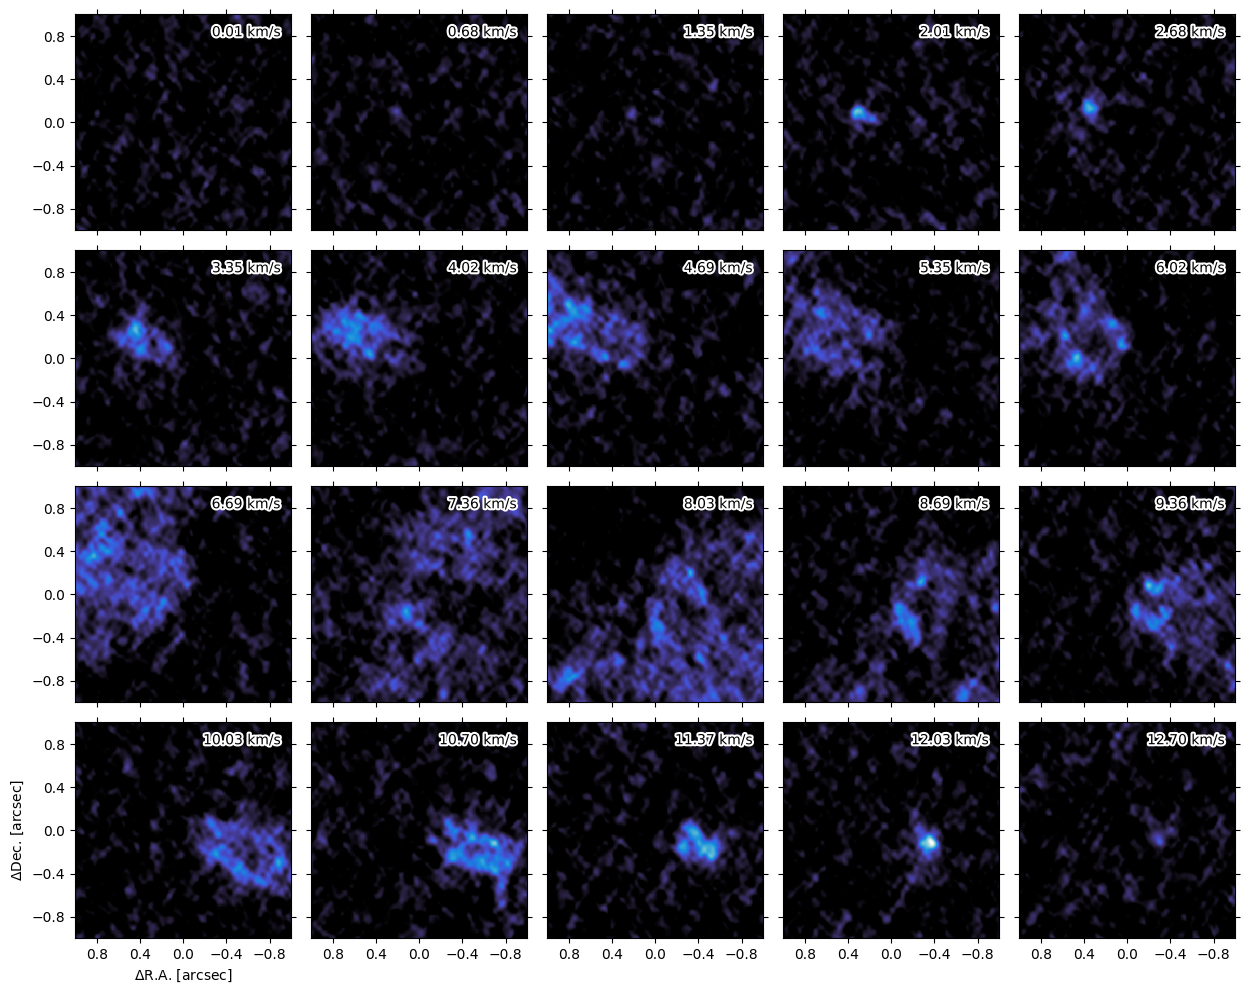

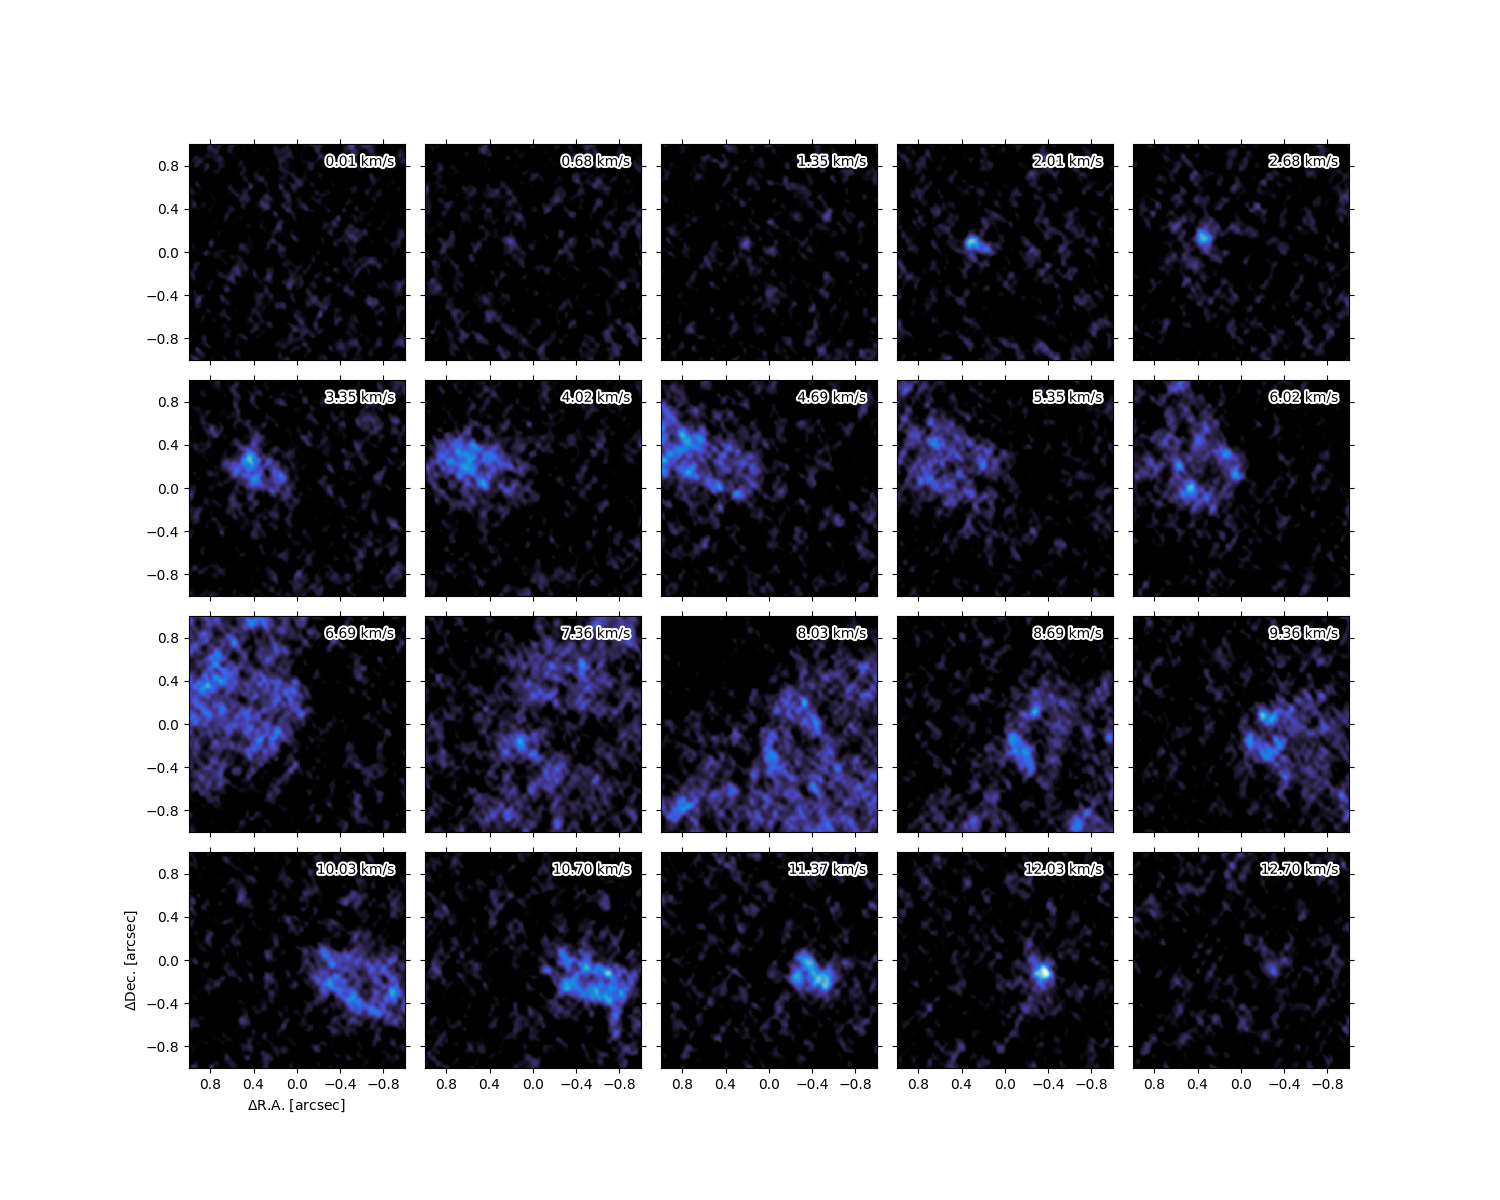

In [3]:
# PV diagram
posax, velax, diagram = calculate_pvdiagram(
    imagename, center_coord=center_coord, PA=69, rrange=(-2, 2)
)


Loading data ...
Calculating PV diagram...
Done.


(-5.500000003919377, 14.37299999235486)

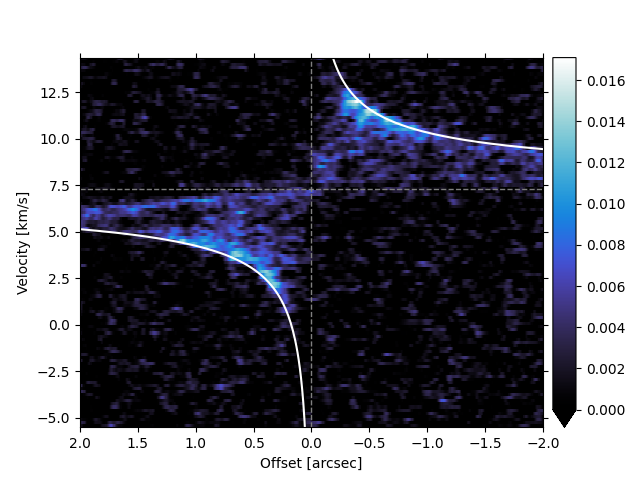

In [4]:
fig, ax = plt.subplots()
utils.plot_2D_map(
    data=diagram,
    X=posax,
    Y=velax,
    ax=ax,
    cmap_method="pcolorfast",
    contour=False,
    cmap_kw=dict(cmap=eplot.cmap["M0"], norm=ImageNormalize(diagram, vmin=0.0)),
)
ax.axhline(y=source_dict[source]["v_sys"], color="grey", ls="dashed", lw=1.0)
ax.axvline(x=0.0, color="grey", ls="dashed", lw=1.0)
ax.set(xlabel="Offset [arcsec]", ylabel="Velocity [km/s]")

r = posax.copy()
vkep_r = (
    Keplerian_velocity(
        r=r[r < 0.0],
        Mstar=1.6,
        distance=source_dict[source]["distance"],
        incl=source_dict[source]["incl"],
    )
    + source_dict[source]["v_sys"]
)
vkep_b = (
    -Keplerian_velocity(
        r=r[r > 0.0],
        Mstar=1.6,
        distance=source_dict[source]["distance"],
        incl=source_dict[source]["incl"],
    )
    + source_dict[source]["v_sys"]
)
ax.plot(posax[posax < 0.0], vkep_r, color="white")
ax.plot(posax[posax > 0.0], vkep_b, color="white")
ax.set_ylim(velax.min(), velax.max())


In [28]:
1000/140

7.142857142857143

In [29]:
2*np.sqrt(13)

7.211102550927978